**Part 2: Linear regression using the numerical data and some numerically transformed categorical data**

In the part 0 we did some basic prepossing. We saw that there were 34 numerical features, and 45 categorical, for a total of 79 features. In part 1 we performed a linear regression using only the 34 numerical features. In this part we incorporate those categorical features which have reasonable numerical transformations. We transform these to numerical features, and perform a linear regression on this enlarged set of numerical features. We begin by reproducing the basic data preprocessing in part 0, ignoring the normalisation step that theoretically has no effect for linear regression.

**Step 1: Reproduce steps 1-4 of part 0**

In [1]:
import pandas as pd
import numpy as np

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Log transformation of train SalePrice
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

print(len(numeric_features_columns))
print(len(categorical_features_columns))

34
45


/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


There are 34 numerical features and 45 categorical features.

**Step 2: Numerically transforming some categorical features**

First we initialise a empty dictionary. We will populate this dictionary with (key, value) pairs, with key equal to a feature, and value equal to a transformation for that feature.

In [2]:
numerical_transformations = {} # Initialise an empty dictionary

Next we choose the features and transformations to populate the above dictionary. We emphasise that these are our choices, and it may work better to choose to transform less (or indeed more) features, and it may work better to choose other numerical transformations.

Take, for example, ExterQual. data_description.txt describes ExterQual as an evaluation the quality of the material on the exterior, with the following possible values:
       
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
       
This is a subjective value assessment of the exterior quality. We choose to numerically transform this via a linear transformation.

In [3]:
def numerically_transform_value_assessment_1(x): # Function which maps Ex to 4, Gd to 3, Ta to 2, Fa to 1, and Po to 0
    if x == 'Ex':
        return 4
    elif x == 'Gd':
        return 3
    elif x == 'TA':
        return 2
    elif x == 'Fa':
        return 1
    else:
        return 0

numerical_transformations['ExterQual'] = numerically_transform_value_assessment_1 # Add (key, value) to the library, where key equals the feature, and value equals the transformation 

There are other features which are identical value assessments (see data_description.txt), and we choose their transformations in the same way.

In [4]:
numerical_transformations['ExterCond'] = numerically_transform_value_assessment_1
numerical_transformations['HeatingQC'] = numerically_transform_value_assessment_1
numerical_transformations['KitchenQual'] = numerically_transform_value_assessment_1
numerical_transformations['PoolQC'] = numerically_transform_value_assessment_1

There are also other features which are different types of value assessments, which we choose to transform as follows.

In [5]:
def numerically_transform_value_assessment_2(x):    
    if x == 'Ex':
        return 5
    elif x == 'Gd':
        return 4
    elif x == 'TA':
        return 3
    elif x == 'Fa':
        return 2
    elif x == 'Po':
        return 1
    else:
        return 0
    
numerical_transformations['BsmtCond'] = numerically_transform_value_assessment_2
numerical_transformations['FireplaceQu'] = numerically_transform_value_assessment_2
numerical_transformations['GarageQual'] = numerically_transform_value_assessment_2
numerical_transformations['GarageCond'] = numerically_transform_value_assessment_2

def numerically_transform_value_assessment_3(x): 
    if x == 'GLQ':
        return 6
    elif x == 'ALQ':
        return 5
    elif x == 'BLQ':
        return 4
    elif x == 'Rec':
        return 3
    elif x == 'LwQ':
        return 2
    elif x == 'Unf':
        return 1
    else:
        return 0
    
numerical_transformations['BsmtFinType1'] = numerically_transform_value_assessment_3
numerical_transformations['BsmtFinType2'] = numerically_transform_value_assessment_3

def numerically_transform_BsmtExposure(x):
    if x == 'Gd':
        return 4
    elif x == 'Av':
        return 3
    elif x == 'Mn':
        return 2
    elif x == 'No':
        return 1
    else:
        return 0
    
numerical_transformations['BsmtExposure'] = numerically_transform_BsmtExposure

def numerically_transform_Functional(x):
    if x == 'Typ':
        return 7
    elif x == 'Min1':
        return 6
    elif x == 'Min2':
        return 5
    elif x == 'Mod':
        return 4
    elif x == 'Maj1':
        return 3
    elif x == 'Maj2':
        return 2
    elif x == 'Sev':
        return 1
    else:
        return 0
    
numerical_transformations['Functional'] = numerically_transform_Functional

def numerically_transform_GarageFinish(x):
    if x == 'Fin':
        return 3
    elif x == 'RFn':
        return 2
    elif x == 'Unf':
        return 1
    else:
        return 0

numerical_transformations['GarageFinish'] = numerically_transform_GarageFinish

Next we come to features which are not necessarily value assessments, but we feel still have reasonable numerical transformations.

According to data_description.txt, BsmtQual evaluates the height of the basement. Our choice for transformation below is inspired by the heights given in the description.

Fence evaluates the quality of fence (the amount privacy it gives). We choose to transform it linearly.

CentralAir has values Y (air conditioning exists) or N. We choose to transform it with value 1 for Y and value 0 for N.

Street has values Pave (paved access) or Grvl (gravel access). We choose to transform it with value 1 for Pave and value 0 for Grvl.

In [6]:
def numerically_transform_BsmtQual(x):
    if x == 'Ex':
        return 105
    elif x == 'Gd':
        return 95
    elif x == 'TA':
        return 85
    elif x == 'Fa':
        return 75
    elif x == 'Po':
        return 65
    else:
        return 0
    
numerical_transformations['BsmtQual'] = numerically_transform_BsmtQual

def numerically_transform_Fence(x):
    if x == 'GdPrv':
        return 4
    elif x == 'MnPrv':
        return 3
    elif x == 'GdWo':
        return 2
    elif x == 'MnWw':
        return 1
    else:
        return 0
    
numerical_transformations['Fence'] = numerically_transform_Fence

def numerically_transform_CentralAir(x):
    if x == 'Y':
        return 1
    else:
        return 0
    
numerical_transformations['CentralAir'] = numerically_transform_CentralAir

def numerically_transform_Street(x):
    if x == 'Pave':
        return 1
    else:
        return 0
    
numerical_transformations['Street'] = numerically_transform_Street

Finally we come to features with few unique entries. Let us first investigate those features. Specifically, we identify and examine those features for which a single value occurs in at least 90% of all data in either train or test.

In [7]:
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > 0.9] # List of all categorical features whose value is unchanged in > 90% of train house data
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > 0.9] # List of all categorical features whose value is unchanged in > 90% of test house data
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries))) # Every feature in the above 2 lists

for feature in categorical_features_list_with_too_few_unique_entries: # For each feature, print the unique train and test value counts
    print(train[feature].value_counts())
    print('')
    print(test[feature].value_counts())
    print('')
    print('')

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Gtl    1396
Mod      60
Sev       3
Name: LandSlope, dtype: int64


Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

Typ     1359
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64


Y    1365
N      95
Name: CentralAir, dtype: int64

Y    1358
N     101
Name: CentralAir, dtype: int64


CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Roll          1
Metal         1
Membran       1
Name: RoofMatl, dtype: int64

CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64


NA    1453
Gd       3
Ex       2
Fa       2
Name: PoolQC, dtype: int64

NA    1456
Ex       2
Gd       1
Name: PoolQC, dtype: int64


NA      1406
Shed      49
Othr       2
Gar2       2
TenC       1
Name: MiscFeature, dtype: int64

NA      1408
Shed      46
Ga

We have already chosen transformations for PoolQC, GarageCond, CentralAir, Functional, Street. We therefore ignore those.

According to data_description.txt, Alley gives the type of alley access to property, and has the following values:

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

Given the small numbers of houses with an alley in both train and test (see the above value_counts), we guess that the type of alley will probably not have a big impact on SalePrice. We therefore choose to transform Alley with value 1 for NA (the most numerous value), and value 0 otherwise (for Grvl or Pave).

LandSlope describes the slope of the property, and has the following values:

       Gtl	Gentle slope
       Mod	Moderate Slope
       Sev	Severe Slope

Given the small numbers of houses with Mod or Sev in both train and test (see the above value_counts), we choose to transform LandSlope with value 1 for Gtl, and value 0 otherwise.

Similarly we choose to transform PavedDrive with value 1 for Y or P, and value 0 otherwise.

Similarly we choose to transform Utilities with value 1 for AllPub, and value 0 otherwise.

We choose not to transform the remaining categorical features with few unique entries as no numerical transformation seems reasonable to us for those particular features (we cannot see any reasonable ranking of the different values).

In [8]:
def numerically_transform_Alley(x):
    if x == 'Grvl' or x == 'Pave':
        return 1
    else:
        return 0
    
numerical_transformations['Alley'] = numerically_transform_Alley

def numerically_transform_LandSlope(x):
    if x == 'Gtl':
        return 1
    else:
        return 0
    
numerical_transformations['LandSlope'] = numerically_transform_LandSlope


def numerically_transform_PavedDrive(x):
    if x == 'Y' or x == 'P':
        return 1
    else:
        return 0
    
numerical_transformations['PavedDrive'] = numerically_transform_PavedDrive

def numerically_transform_Utilities(x):
    if x == 'AllPub':
        return 1
    else:
        return 0
    
numerical_transformations['Utilities'] = numerically_transform_Utilities

Let us now check the features we have chosen.

In [9]:
categorical_features_to_convert_to_numerical = list(numerical_transformations.keys()) # A list of all the features to transform/dictionary keys
sorted(categorical_features_to_convert_to_numerical)

['Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'ExterCond',
 'ExterQual',
 'Fence',
 'FireplaceQu',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'HeatingQC',
 'KitchenQual',
 'LandSlope',
 'PavedDrive',
 'PoolQC',
 'Street',
 'Utilities']

We now transform the chosen features.

In [10]:
for feature in categorical_features_to_convert_to_numerical: # For every categorical feature to transform to numerical
    train[feature] = train[feature].apply(numerical_transformations[feature]) # Apply the transformation to the train feature
    test[feature] = test[feature].apply(numerical_transformations[feature]) # Apply the transformation to the test feature
    categorical_features_columns.remove(feature) # Remove the feature from the categorical list
    numeric_features_columns.append(feature) # Add the feature to the numerical list

At this point we stop with the numerical transformations. Let us check the new numbers of numerical and categorical features.

In [11]:
print(len(numeric_features_columns))
print(len(categorical_features_columns))

56
23


We have enlarged the numerical features by 19, from 34 to 56, and there remains 23 categorical features.

**Step 3: Linear regression using the enlarged numeric feature set**

We now make our second set of predictions: Linear regression using the 56 numeric features in the enlarged set.
First the train test split. The code is identical to that in step 2 of part 1, and so we simply reproduce it here.

0.15171881654766137


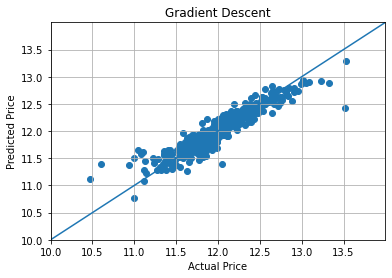

In [12]:
X = train[numeric_features_columns]
Y = train_sale_price.copy()

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

This is similar to the score we obtained in part 1 for our train test split. Next the linear regression using the whole of X and Y.

In [13]:
model = lr.fit(X, Y)
X_test = test[numeric_features_columns]
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Submitting this file to kaggle gives a **RMSE score of 0.14555**. This is slightly better than our result in part 1, using only the original 34 numerical features.

We again emphasise that the features transformed above were simply our choices. It may work better to choose to transform less, or more, features. It may work better to choose other numerical transformations than those used above.